# Age Classification Analysis

This notebook implements and compares optimized KNN and Logistic Regression models for age prediction using facial images.

## Table of Contents
1. Setup and Data Loading
2. Data Preprocessing and Augmentation
3. Model Training and Optimization
4. Results Comparison

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, log_loss
from scipy.ndimage import rotate
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_augment_data(data_path, min_age=1, max_age=4):
    data = glob(data_path)
    ages = []
    images = []
    
    print("Loading and augmenting images...")
    for image_file in data:
        filename = os.path.basename(image_file)
        try:
            age = int(filename.split('_')[0])
            if min_age <= age <= max_age:
                # Load original image
                image = Image.open(image_file).convert('L').resize((64, 64))
                image = np.array(image) / 255.0
                
                # Original image
                images.append(image)
                ages.append(age)
                
                # Horizontal flip
            
                
        except ValueError:
            continue
    
    return np.array(images, dtype=np.float32), np.array(ages, dtype=np.int32)

# Load and augment data
images, ages = load_and_augment_data('dataset/utkface_aligned_cropped/crop_part1/*.jpg')
print(f"Total samples after augmentation: {len(images)}")

# Flatten images
X = images.reshape(len(images), -1)
y = ages

Loading and augmenting images...
Total samples after augmentation: 2131


## 2. Data Preprocessing and Analysis

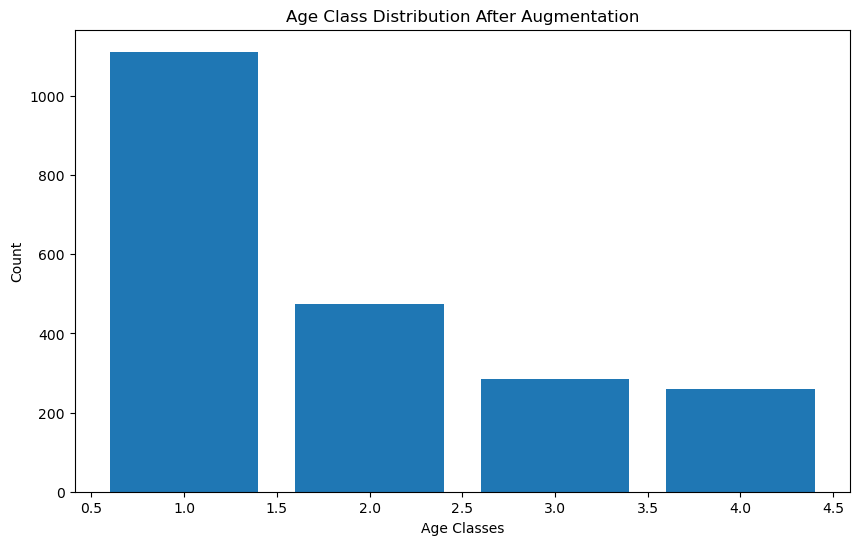

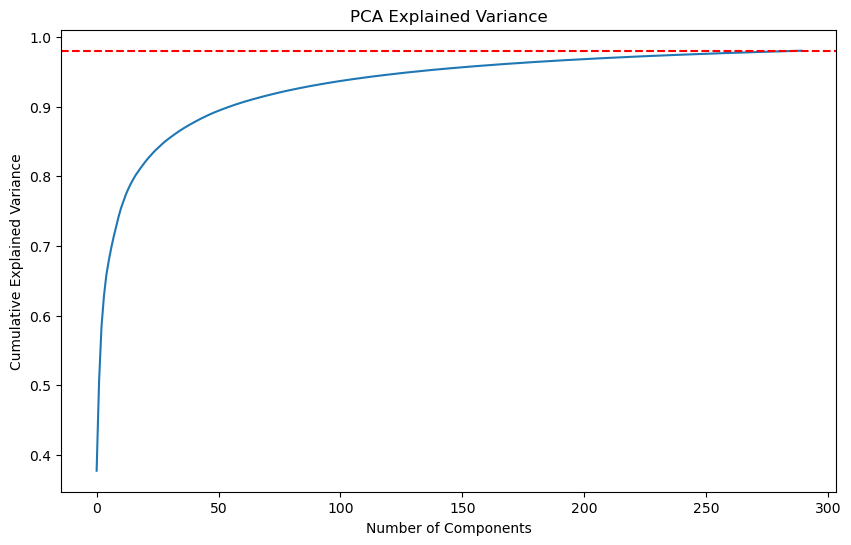

Reduced dimensions: 290


In [3]:
# Plot age distribution
plt.figure(figsize=(10, 6))
age_classes, counts = np.unique(y, return_counts=True)
plt.bar(age_classes, counts)
plt.xlabel("Age Classes")
plt.ylabel("Count")
plt.title("Age Class Distribution After Augmentation")
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot PCA explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.axhline(y=0.98, color="r", linestyle="--")
plt.show()

print(f"Reduced dimensions: {X_train_pca.shape[1]}")

## 3. Model Training and Optimization


KNN Results:
Accuracy: 0.5269
Macro-Average AUC: 0.6050
Log Loss: 8.7644

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.88      0.70       223
           2       0.36      0.20      0.26        95
           3       0.15      0.05      0.08        57
           4       0.46      0.12      0.18        52

    accuracy                           0.53       427
   macro avg       0.39      0.31      0.30       427
weighted avg       0.46      0.53      0.45       427



<Figure size 800x600 with 0 Axes>

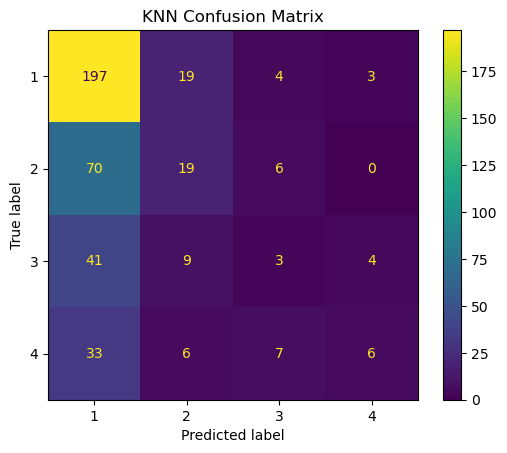


Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}


/usr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Fr


Logistic Regression Results:
Accuracy: 0.5457
Macro-Average AUC: 0.7335
Log Loss: 1.3244

Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.76      0.74       223
           2       0.29      0.25      0.27        95
           3       0.31      0.26      0.28        57
           4       0.42      0.48      0.45        52

    accuracy                           0.55       427
   macro avg       0.43      0.44      0.43       427
weighted avg       0.53      0.55      0.54       427



<Figure size 800x600 with 0 Axes>

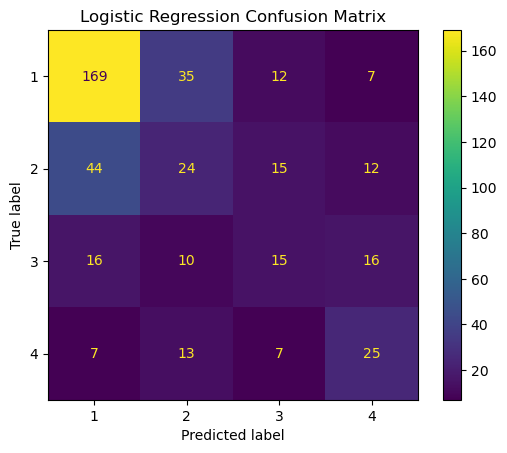


Best Logistic Regression parameters: {'C': 0.1, 'max_iter': 1000, 'solver': 'newton-cg'}


In [4]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    macro_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    loss = log_loss(y_test, y_proba)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-Average AUC: {macro_auc:.4f}")
    print(f"Log Loss: {loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'macro_auc': macro_auc,
        'log_loss': loss,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Optimize and train KNN
knn_params = {
    'n_neighbors': [3, 4, 5, 6],
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean']
}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)
knn_results = train_and_evaluate_model(knn, X_train_pca, X_test_pca, y_train, y_test, "KNN")
print(f"\nBest KNN parameters: {knn.best_params_}")

# Optimize and train Logistic Regression
lr_params = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'newton-cg'],
    'max_iter': [1000]
}
lr = GridSearchCV(LogisticRegression(multi_class='multinomial'), lr_params, cv=5, n_jobs=-1)
lr_results = train_and_evaluate_model(lr, X_train_pca, X_test_pca, y_train, y_test, "Logistic Regression")
print(f"\nBest Logistic Regression parameters: {lr.best_params_}")

## 4. Model Comparison

Model Performance Comparison:


,KNN,Logistic Regression
Metric,,
Accuracy,0.526932,0.545667
Macro-Average AUC,0.604950,0.733457
Log Loss,8.764438,1.324405


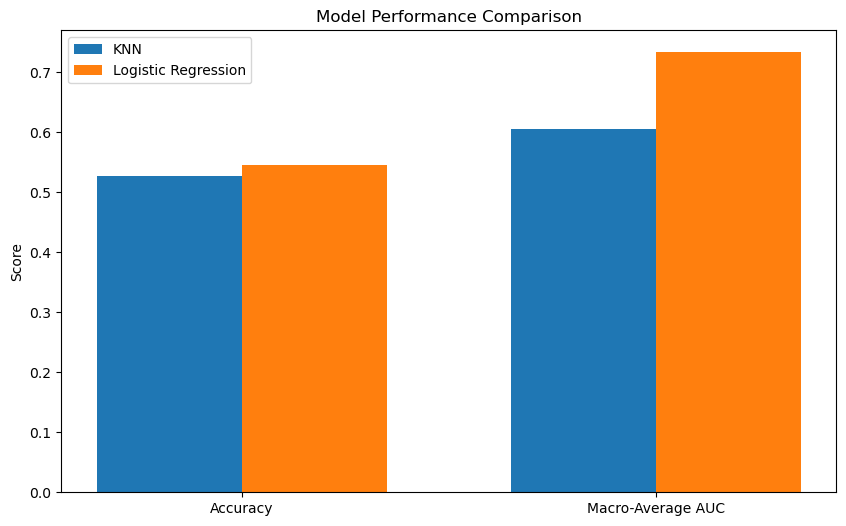

In [5]:
# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Macro-Average AUC', 'Log Loss'],
    'KNN': [knn_results['accuracy'], knn_results['macro_auc'], knn_results['log_loss']],
    'Logistic Regression': [lr_results['accuracy'], lr_results['macro_auc'], lr_results['log_loss']]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Metric', inplace=True)
print("Model Performance Comparison:")
display(comparison_df)

# Plot comparison bar chart
metrics = ['Accuracy', 'Macro-Average AUC']
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [knn_results['accuracy'], knn_results['macro_auc']], 
        width, label='KNN')
plt.bar(x + width/2, [lr_results['accuracy'], lr_results['macro_auc']], 
        width, label='Logistic Regression')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.show()